# Anomaly Detection

1. Core concepts
    - Identifying data points/events that deviate from the norm
    - The output will generate minority class in the data
    - Used to detect: fraud, errors, malicious attacks, unusual patterns, etc..
2. Anomaly Detection vs Outlier Treatment
    - Outlier Treatment: remove/handle outliers based on a  single feature
    - Anomaly Detection: identify patterns using multiple-feature analysis
3. Machine Learning Approaches:
    - Supervised:
        - when we have labeled data (fraud vs no-fraud)
        - ML Algo: e.g. Logistic Regression, SVM, Decision Trees...
        - Best when: when we have sufficient labeled examples
    - Unsupervised Learning
        - No labeled target 
        - ML Algo: Isolation FOrest, DBSCAN, kNN, ABOD, etc...
4. Considerations:
    - Need domain expertise to validate the detected anomalies
    - Feature engineering is very important
    - Regular model updates are needed to adapt to new patterns


## Using Clustering with kNN

- kNN: k-nearest neighbor
- It can be used for both classification and anomaly detection
- Technique:
    - It measures the "nearness" of the data points
    - k-value hyperparameter is chosen to adjust the number of nearest neighbors 
- Steps:
    1. Deploy your kNN model with k-value
    2. Calculate the distances between data points and indices of the nearest neighbors 
    3. Calculate the mean of all k-distances (for every observation)
    4. Plot the data for the distances
    5. Determine the cutoff point based on the desired outlier value

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotx

#ML
from sklearn.datasets import load_iris
from sklearn.neighbors import NearestNeighbors

In [2]:
plt.style.use(matplotx.styles.dracula)

In [3]:
iris_data = load_iris()

print(iris_data['DESCR'])

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr

- while we can perform anomaly detection for all features, we'll use only 2 features for this exercise

In [4]:
iris_data['feature_names'][:2]

['sepal length (cm)', 'sepal width (cm)']

In [5]:
df = pd.DataFrame(iris_data.data[:,:2], columns=list(iris_data['feature_names'][:2]))
df.head()

,sepal length (cm),sepal width (cm)
0,5.1,3.5
1,4.9,3.0
2,4.7,3.2
3,4.6,3.1
4,5.0,3.6


<Axes: xlabel='sepal length (cm)', ylabel='sepal width (cm)'>

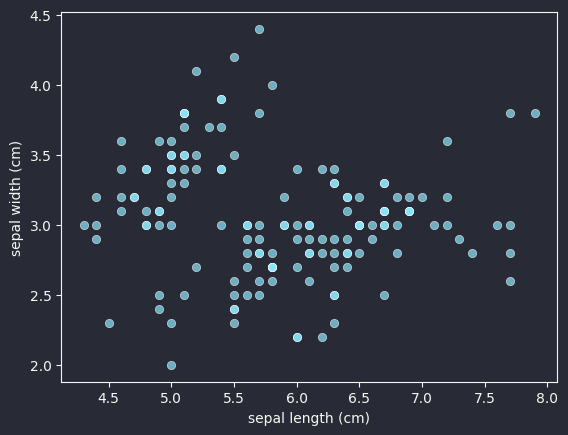

In [6]:
sns.scatterplot(data=df, x='sepal length (cm)', y='sepal width (cm)', alpha=.7)

Step 1

In [7]:
knn_model = NearestNeighbors(n_neighbors=3)

#fit the model
knn_model.fit(df)

NearestNeighbors(n_neighbors=3)

Step 2

- distances: an array that represents the lengths of points between each other
- indices: an array that represents the nearest points in the population matrix

In [8]:
distances, indices = knn_model.kneighbors(df)

In [9]:
mean_distances = distances.mean(axis=1)
mean_distances[:10]

array([0.03333333, 0.06666667, 0.03333333, 0.08047379, 0.06666667,
       0.06666667, 0.13333333, 0.03333333, 0.08047379, 0.03333333])

Step 4

Text(0, 0.5, 'Avg Distances')

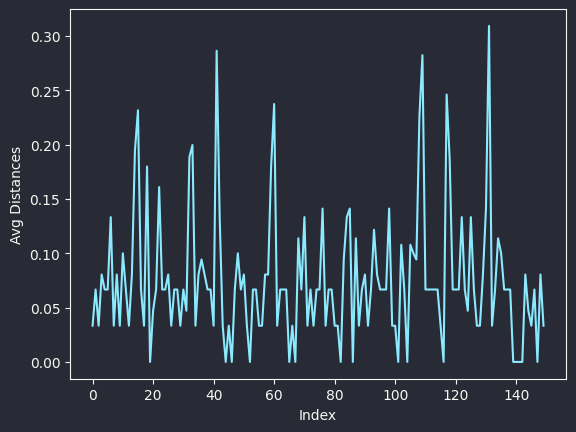

In [10]:
plt.plot(mean_distances)
plt.xlabel('Index')
plt.ylabel('Avg Distances')

- The plot above shows the data points with the highest average distance from every other data points (neighboring points)
- We can see spikes that represent the highest distances -> anomalies
- It seems 0.15 is a good threshold to spot the anomalies (or split between minority and majority)
- To isolate them, we can get the index value of the anomalies

In [11]:
threshold = 0.15

Text(0.5, 1.0, 'Mean Distances Evaluation with 0.15 Threshold')

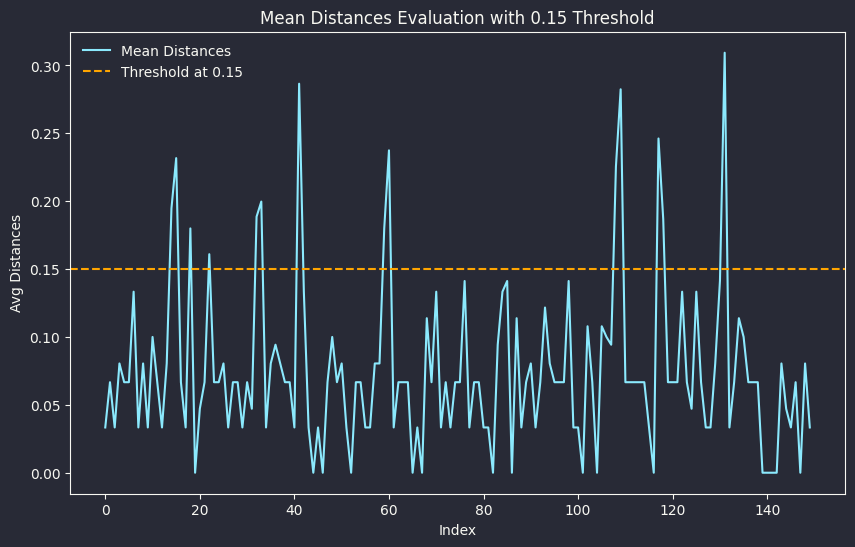

In [12]:
plt.figure(figsize=(10,6))

plt.plot(mean_distances, label='Mean Distances')
plt.axhline(y=threshold, color='orange', label=f'Threshold at {threshold}', linestyle='--')

plt.xlabel('Index')
plt.ylabel('Avg Distances')
plt.legend()
plt.title(f'Mean Distances Evaluation with {threshold} Threshold')

In [13]:
anomaly_indices = np.where(mean_distances>threshold)[0]
anomaly_indices

array([ 14,  15,  18,  22,  32,  33,  41,  59,  60, 108, 109, 117, 118,
       131])

Add a column to identify the anomalies 

In [14]:
df['kNN Anomaly'] = np.where(df.index.isin(anomaly_indices),1,0)
df.sample(8)

,sepal length (cm),sepal width (cm),kNN Anomaly
52,6.9,3.1,0
114,5.8,2.8,0
43,5.0,3.5,0
55,5.7,2.8,0
85,6.0,3.4,0
148,6.2,3.4,0
17,5.1,3.5,0
102,7.1,3.0,0


<Axes: xlabel='sepal length (cm)', ylabel='sepal width (cm)'>

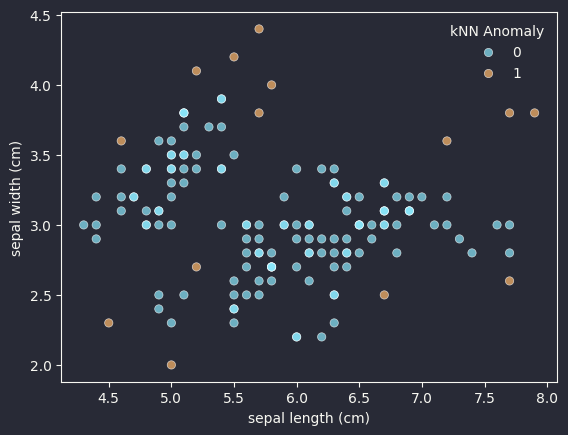

In [15]:
sns.scatterplot(data=df, x='sepal length (cm)', y='sepal width (cm)', alpha=.7, hue='kNN Anomaly')

## Anomaly Detection Using PyOD

`pip install pyod`

- It's an open-source python library for outlier detection
- It offers over 25 different algorithms
- Popular algorithms:
    - IForest (Isolation Forest): It creates multiple decision trees (ensemble learning)
    - ABOD (Angle-Based Outlier Detection): It measures the angles between the data points and calculates the variance compared to its neighbors
    - OCSVM (One-Class Support Vector Machine): looks for a hyperplane to maximally separate data points from the origin (majority vs minority)

- For this exercise, we'll be using all 4 features
- We'll use PCA to visualize

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [17]:
# get all columns
X = iris_data.data

#Standardize the data
SS = StandardScaler()
X_scaled = SS.fit_transform(X)

In [18]:
#PCA for visualization
pca_model = PCA(n_components=2)
X_pca = pca_model.fit_transform(X_scaled)

### IForest

In [19]:
from pyod.models.iforest import IForest

To control the threshold/intensity of identifying the outliers, use `contamination`

In [20]:
iforest_model = IForest(contamination=0.16, random_state=10)

In [22]:
#fit the model
iforest_model.fit(X_scaled)


IForest(behaviour='old', bootstrap=False, contamination=0.16,
    max_features=1.0, max_samples='auto', n_estimators=100, n_jobs=1,
    random_state=10, verbose=0)

In [23]:
#get the predicted anomalies
iforest_pred = iforest_model.predict(X_scaled)

> you can do the above all in one shot: `iforest_model.fit_predict(X_scaled)`

In [24]:
df_pca = pd.DataFrame({'PC1': X_pca[:,0],
                       'PC2': X_pca[:,1],
                       'iforest_pred':iforest_pred})

In [25]:
df_pca.head()

,PC1,PC2,iforest_pred
0,-2.264703,0.480027,0
1,-2.080961,-0.674134,0
2,-2.364229,-0.341908,0
3,-2.299384,-0.597395,0
4,-2.389842,0.646835,0


Text(0.5, 1.0, 'Anomaly Detection Using IForest Algo')

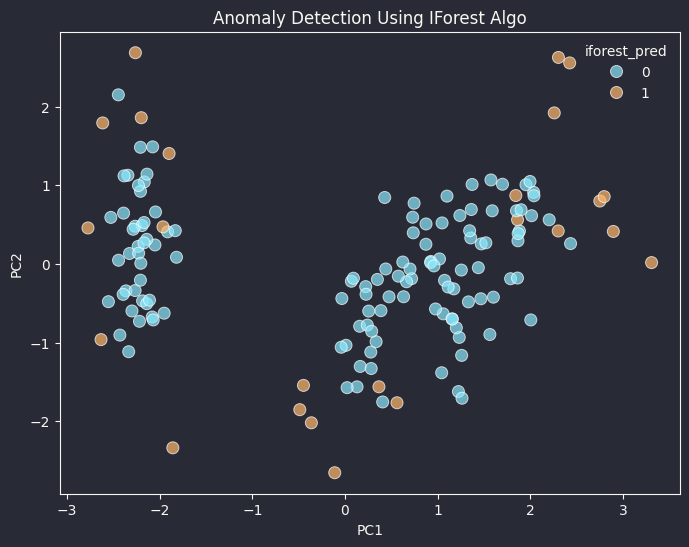

In [27]:
plt.figure(figsize=(8,6))

sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='iforest_pred', alpha=0.7, s=75)
plt.title('Anomaly Detection Using IForest Algo')

**Homework**: 
1. apply variance ratio analysis and loadings to understand the influence of the 4 features.
2. test the anomaly detection on the PCs instead of full dataset

In [28]:
df = pd.DataFrame(X, columns=iris_data['feature_names'])
df['IForest Anomaly'] = iforest_pred
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),IForest Anomaly
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [29]:
df[df['IForest Anomaly']==1]

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),IForest Anomaly
13,4.3,3.0,1.1,0.1,1
14,5.8,4.0,1.2,0.2,1
15,5.7,4.4,1.5,0.4,1
18,5.7,3.8,1.7,0.3,1
22,4.6,3.6,1.0,0.2,1
32,5.2,4.1,1.5,0.1,1
41,4.5,2.3,1.3,0.3,1
43,5.0,3.5,1.6,0.6,1
57,4.9,2.4,3.3,1.0,1
60,5.0,2.0,3.5,1.0,1


In [32]:
import plotly.express as px

fig = px.scatter_3d(df, x='sepal width (cm)', y='sepal length (cm)', z='petal width (cm)',
              color='IForest Anomaly')

fig.show()

## ABOD

In [33]:
from pyod.models.abod import ABOD

In [34]:
abod_model = ABOD(contamination=0.12) #make sure you perform hyperparameter tuning

In [35]:
abod_model.fit(X_scaled)
abod_pred = abod_model.predict(X_scaled)


In [36]:
df_pca['abod_pred'] = abod_pred

Text(0.5, 1.0, 'Anomaly Detection Using ABOD Algo')

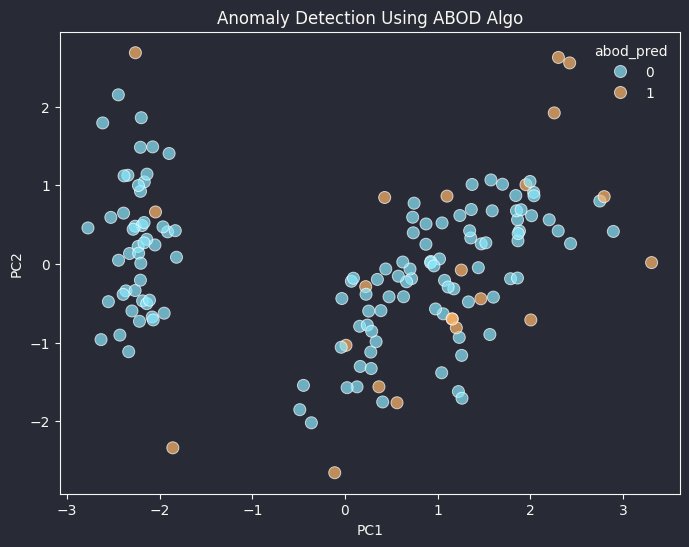

In [38]:
plt.figure(figsize=(8,6))

sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='abod_pred', alpha=0.7, s=75)
plt.title('Anomaly Detection Using ABOD Algo')

In [39]:
from pyod.models.ocsvm import OCSVM

ocsvm_model = OCSVM(contamination=0.14)

In [40]:
ocsvm_model.fit(X_scaled)

ocsvm_pred = ocsvm_model.predict(X_scaled)

## Side-by-Side Comparison

In [45]:
df['OCSVM Anomaly'] = ocsvm_pred
df['ABOD Anomaly'] = abod_pred

In [49]:
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),IForest Anomaly,OCSVM Anomaly,ABOD Anomaly
0,5.1,3.5,1.4,0.2,0,0,0
1,4.9,3.0,1.4,0.2,0,0,0
2,4.7,3.2,1.3,0.2,0,0,0
3,4.6,3.1,1.5,0.2,0,0,0
4,5.0,3.6,1.4,0.2,0,0,0


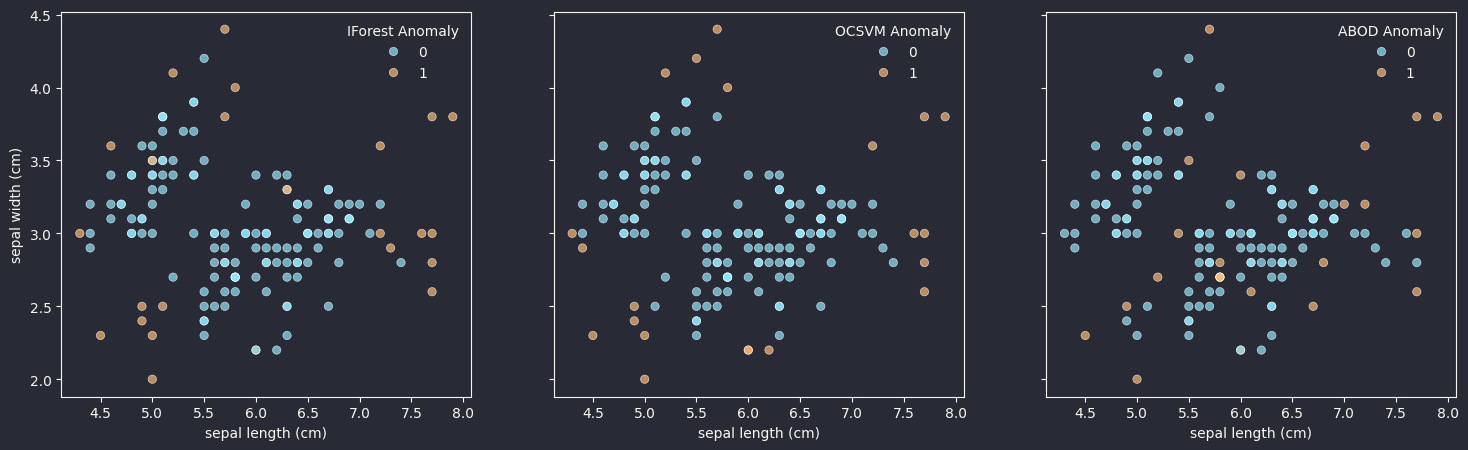

In [54]:
fig, axes = plt.subplots(1,3,figsize=(18,5), sharey=True)

plot0 = sns.scatterplot(x=df['sepal length (cm)'], y=df['sepal width (cm)'], alpha=0.7, hue=df['IForest Anomaly'], ax=axes[0])
plot1 = sns.scatterplot(x=df['sepal length (cm)'], y=df['sepal width (cm)'], alpha=0.7, hue=df['OCSVM Anomaly'], ax=axes[1])
plot2 = sns.scatterplot(x=df['sepal length (cm)'], y=df['sepal width (cm)'], alpha=0.7, hue=df['ABOD Anomaly'], ax=axes[2])


**Homework** redo kNN method with all 4 columns and compare it to the plots above.